<a href="https://colab.research.google.com/github/eduardasantanab/pre-processamento-final/blob/main/pre-processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Operações básicas: exibir imagem

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Função para exibir imagem dentro do notebook.
def exibir_imagem_plt(img):
	img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
	plt.imshow(img)
	print(f"Dimensões da imagem: {img.shape[:2]}")

In [ ]:
# Exibindo a imagem externamente usando o OpenCv
def exibir_imagem_cv(img):
	cv.imshow("IMAGE", img)
	cv.waitKey(0)
	cv.destroyAllWindows()

In [ ]:
#define a imagem
img = cv.imread('mdb124.pgm')
assert img is not None, 'arquivo não pode ser lido'

## Filtragem de suavização

-> Filtro da média

In [ ]:
#exibe a imagem antes da filtragem
exibir_imagem_plt(img)

In [ ]:
#aplica o filtro da média
filtrada = cv.blur(img, (5, 5))

In [ ]:
#exibe a imagem filtrada
exibir_imagem_plt(filtrada)

-> Filtro da mediana

In [ ]:
#aplica o filtro de suavizacao da mediana
filtrada = cv.medianBlur(img, 5)

In [ ]:
#exibe a imagem filtrada
exibir_imagem_plt(filtrada)

## Filtragem de realce

In [ ]:
#converte a imagem para preto e branco
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
exibir_imagem_plt(gray)

In [ ]:
#aplica filtro de realce nos gradientes x e y
grad_x = cv.Sobel(gray, -1, 1, 0, ksize=5)
grad_y = cv.Sobel(gray, -1, 0, 1, ksize=5)

In [ ]:
#converte gradientes para o valor absoluto
abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)

In [ ]:
#interpola os gradientes absolutos
grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

In [ ]:
#exibe a imagem filtrada
exibir_imagem_plt(grad)

##### Uma outra forma de aplicar o filtro de realce:


In [ ]:
#Máscara de Prewitt
kernel_x = np.array([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]])

kernel_y = np.array([[-1, -1, -1],
                    [0, 0, 0],
                    [1, 1, 1]])

grad_x = cv.filter2D(gray, -1, kernel_x)
grad_y = cv.filter2D(gray, -1, kernel_y)

abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)

grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

exibir_imagem_plt(grad)

# Pré-pocessamento de imagem

#### Manipulação da base de dados

In [ ]:
import pandas as pd

#tabela = pd.read_csv("base-dados.csv", sep=",")

tabela = pd.read_csv('base-dados-ok.csv', index_col= "num_ref_dbMIA", usecols= [0, 4, 5, 6, 7])
display(tabela)

#### Converte colunas de operações para tipo inteiro

In [ ]:
# Altera o tipo de dado das colunas de operação

df = pd.read_csv('base-dados-ok.csv', dtype = {"num_ref_dbMIA": "category"})
df['coordenada_x_centro_anormalidade'] = df['coordenada_x_centro_anormalidade'].astype(int)
df['coordenada_y_centro_anormalidade'] = df['coordenada_y_centro_anormalidade'].astype(int)
df['raio_circunferencia_anormalidade (pixels)'] = df['raio_circunferencia_anormalidade (pixels)'].astype(int)

df.dtypes

#### Segmentação de imagens anormais

In [ ]:
# Acessa a base para tratar todas as imagens

for i, valor in tabela['classe2_anormalidade'].iteritems():

  if valor == 'ANORM':
    nome_arquivo = str(i).replace(" ", "") + '.pgm'
    aux_nome_arquivo = str(i).replace(" ", "") + '_mod.png'
    img = cv.imread(nome_arquivo, 0)

    # Aplica o negativo da imagem
    if img is not None:
      rows, cols = img.shape
      for n in range(rows):
        for j in range(cols):
          img[n, j] = 255 - img[n, j]
    else:
      print("Falha ao carregar a imagem.")

    # Segmenta a imagem
    x = tabela.loc[str(i), 'coordenada_x_centro_anormalidade']
    y = tabela.loc[str(i), 'coordenada_y_centro_anormalidade']
    raio = tabela.loc[str(i), 'raio_circunferencia_anormalidade (pixels)']

    print(aux_nome_arquivo)

    if x != -1:
      tamanho_imagem = 1024
      raio_padrao = 256
      x_centro = x - raio
      y_centro = tamanho_imagem - y - raio
      croped = img[y_centro: y_centro + raio_padrao, x_centro : x_centro + raio_padrao]
      cv.imwrite(aux_nome_arquivo, croped)

      largura = croped.shape[1]
      altura = croped.shape[0]

      if largura < 256 or altura < 256:
        #redimensiona a imagem cortada
        imagem_redimensionada = cv.resize(croped, (256, 256))
        cv.imwrite(aux_nome_arquivo, imagem_redimensionada)

    else:
      scale_percentage = 25
      o_heigth, o_width = img.shape[:2]
      mod_width = int(o_width * scale_percentage / 100)
      mod_heigth = int(o_heigth * scale_percentage / 100)
      mod_dim = (mod_width, mod_heigth)
      o_dim = (o_width, o_heigth)

      downsized_img = cv.resize(img, mod_dim,interpolation=cv.INTER_AREA)
      cv.imwrite(aux_nome_arquivo, downsized_img)

#### Redimensionamento de imagens normais

In [ ]:
for i, valor in tabela['classe2_anormalidade'].iteritems():
    nome_arquivo = str(i).replace(" ", "") + '.pgm'
    aux_nome_arquivo = str(i).replace(" ", "") + '_mod.png'
    img = cv.imread(nome_arquivo, 0)

    # Aplica o negativo da imagem
    if img is not None:
      rows, cols = img.shape
      for n in range(rows):
        for j in range(cols):
          img[n, j] = 255 - img[n, j]
    else:
      print("Falha ao carregar a imagem.")

    # Redimensiona a imagem
    raio = tabela.loc[str(i), 'raio_circunferencia_anormalidade (pixels)']

    if raio == -1 and valor != 'ANORM':
      scale_percentage = 25
      o_heigth, o_width = img.shape[:2]
      mod_width = int(o_width * scale_percentage / 100)
      mod_heigth = int(o_heigth * scale_percentage / 100)
      mod_dim = (mod_width, mod_heigth)
      o_dim = (o_width, o_heigth)

      print(aux_nome_arquivo)

      downsized_img = cv.resize(img, mod_dim,interpolation=cv.INTER_AREA)
      cv.imwrite(aux_nome_arquivo, downsized_img)

# Passo a passo para uma única imagem




#### Aplica negativo da imagem

Dimensões da imagem: (1024, 1024)


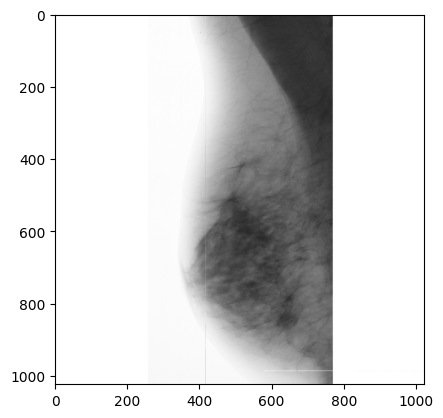

In [ ]:
import cv2
img = cv2.imread('mdb199.pgm', 0)  # 0 para imagem em escala de cinza

if img is not None:
    rows, cols = img.shape
    for i in range(rows):
        for j in range(cols):
            img[i, j] = 255 - img[i, j]
else:
    print("Falha ao carregar a imagem.")

exibir_imagem_plt(img)


#### Recorte da área do tumor

Dimensões da imagem: (256, 256)


True

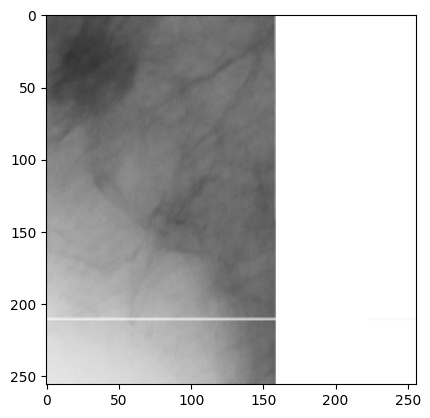

In [ ]:
# Dados da imagem original
x = 641
y = 177
raio_imagem = 31

# Segmentação
tamanho_imagem = 1024
raio_padrao = 256
x_centro = x - raio_imagem
y_centro = tamanho_imagem - y - raio_imagem

croped = img[y_centro: y_centro + raio_padrao, x_centro : x_centro + raio_padrao]
imagem_redimensionada = cv.resize(croped, (256, 256))


exibir_imagem_plt(imagem_redimensionada)
cv.imwrite('mdb199_mod.png', imagem_redimensionada)

#### Redimensionamento

Dimensões da imagem: (256, 256)


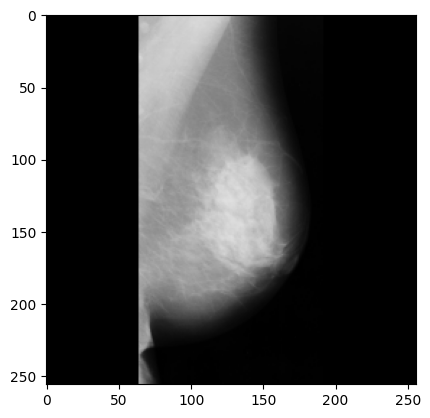

In [ ]:

scale_percentage = 25
o_heigth, o_width = img.shape[:2]
mod_width = int(o_width * scale_percentage / 100)
mod_heigth = int(o_heigth * scale_percentage / 100)
mod_dim = (mod_width, mod_heigth)
o_dim = (o_width, o_heigth)

downsized_img = cv.resize(img, mod_dim,interpolation=cv.INTER_AREA)

# Salva a imagem modificada
cv.imwrite('normal_modificada.png', downsized_img)
exibir_imagem_plt(downsized_img)